In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import torch

from actioncard import Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch
from aiutils import load, save
from buyagenda import BigMoneyBuyAgenda
from config import GameConfig
from constants import BUY
from enums import StartingSplit
from env import DefaultEnvironment
from player import HeuristicPlayer, load_players, PredictorMLPPlayer
from simulations import simulate

In [3]:
default_kingdom = [Chapel, Moat, Village, Militia, Moneylender, Smithy, CouncilRoom, Laboratory, Market, Witch]

In [4]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

## First-mover advantage ##

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [7]:
config = GameConfig(splits=[StartingSplit.Starting34Split, StartingSplit.Starting34Split], sandbox=True, num_players=2)
players = load_players(['BM', 'BM'], None, map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [192]:
n = 10000

In [173]:
sim_stats = simulate(env, 10000, None, turn_log=True)

100%|██████████| 10000/10000 [02:34<00:00, 64.87it/s]
===SUMMARY===
{0: 6899, 1: 5659, 'ProvinceWins': 10000, 'Ties': 2558}


In [174]:
df = sim_stats.turn_df
df.head()

,Iter,Player,Score,Card,Turn
0,0,0,3,Silver,0
1,0,1,3,Silver,0
2,0,0,3,Silver,1
3,0,1,3,Silver,1
4,0,0,3,Silver,2


In [199]:
player_df = sim_stats.player_df
player_df.head()

In [213]:
game_df = sim_stats.game_df
game_df.head()

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,33.0,True,0.013197,False
1,33.0,True,0.014179,False
2,30.0,True,0.012512,False
3,30.0,True,0.013902,False
4,30.0,True,0.013222,False


In [203]:
p0_df, p1_df = df[df['Player']==0], df[df['Player']==1]
p0_game_df, p1_game_df = player_df[player_df['Player']==0].reset_index(drop=True), player_df[player_df['Player']==1].reset_index(drop=True)
p0_game_df.head()

,Turns,Player,Score,Won,Iter
0,15,0,21.0,False,1
1,17,0,33.0,True,2
2,15,0,30.0,True,3
3,17,0,27.0,False,4
4,16,0,30.0,True,5


In [226]:
p0_max_turn = p0_df[['Iter', 'Turn']].groupby('Iter').max()
p1_max_turn = p1_df[['Iter', 'Turn']].groupby('Iter').max()
n_extra_turn = (p0_max_turn > p1_max_turn).sum().item()
print('All following probabilities refer to starting player.')

n_ties = game_df['Tie'].sum()
n_wins = p0_game_df["Won"].sum() - n_ties
print(f'P(Win) = {(n_wins / n) * 100:.2f}%')
print(f'P(Loss) = {(n - n_wins - n_ties) / n * 100:.2f}%')
print(f'P(Tie) = {n_ties / n * 100:.2f}%\n')

print(f'Starting player gets extra turn (i.e. ends game) {n_extra_turn / n * 100}% of the time.')

diff = p0_max_turn - p1_max_turn
p0_win_given_extra_turn = p0_game_df[(p0_game_df['Won'] == True) & (diff['Turn'] == 1) & (game_df['Tie'] == False)]
p0_loss_given_extra_turn = p0_game_df[(p0_game_df['Won'] == False) & (diff['Turn'] == 1) & (game_df['Tie'] == False)]
p0_tie_given_extra_turn = p0_game_df[(diff['Turn'] == 1) & (game_df['Tie'] == True)]
print(f'P(Wins | Extra Turn) = {len(p0_win_given_extra_turn) / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Extra Turn) = {len(p0_loss_given_extra_turn) / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Extra Turn) = {len(p0_tie_given_extra_turn) / n_extra_turn * 100:.2f}%')

print('')

p0_win_equal_turn = p0_game_df[(p0_game_df['Won'] == True) & (diff['Turn'] == 0) & (game_df['Tie'] == False)]
p0_loss_equal_turn = p0_game_df[(p0_game_df['Won'] == False) & (diff['Turn'] == 0) & (game_df['Tie'] == False)]
p0_tie_equal_turn = p0_game_df[(diff['Turn'] == 0) & (game_df['Tie'] == True)]
print(f'P(Wins | Equal Turn) = {len(p0_win_equal_turn) / n_extra_turn * 100:.2f}%')
print(f'P(Loses | Equal Turn) = {len(p0_loss_equal_turn) / n_extra_turn * 100:.2f}%')
print(f'P(Ties | Equal Turn) = {len(p0_tie_equal_turn) / n_extra_turn * 100:.2f}%')

All following probabilities refer to starting player.
P(Win) = 43.41%
P(Loss) = 31.01%
P(Tie) = 25.58%

Starting player gets extra turn (i.e. ends game) 49.62% of the time.
P(Wins | Extra Turn) = 56.31%
P(Loses | Extra Turn) = 19.39%
P(Ties | Extra Turn) = 24.30%

P(Wins | Equal Turn) = 31.18%
P(Loses | Equal Turn) = 43.11%
P(Ties | Equal Turn) = 27.25%


In 10k games between BM BM, we have 43.34%/32.12%/24.54% WLT split for random starting split. 43.36%/31.96%/24.68% for 2/5 split. 42.85%/32.18%/24.97% for 3/4 split. Corresponds to starting advantage of 11.22%, 11.4%, 10.67%, resp. 

* Why is the starting advantage 10%? 
* Why does 2/5 not have as large an advantage as 3/4? 

In [36]:
temp = p0_df[p0_df['Card'] == 'Province']
p0firstprovinceturn = temp[['Iter', 'Card', 'Turn']].groupby(['Iter', 'Card']).min()
temp = p1_df[p1_df['Card'] == 'Province']
p1firstprovinceturn = temp[['Iter', 'Card', 'Turn']].groupby(['Iter', 'Card']).min()
firstprovinceturndiff = p0firstprovinceturn - p1firstprovinceturn

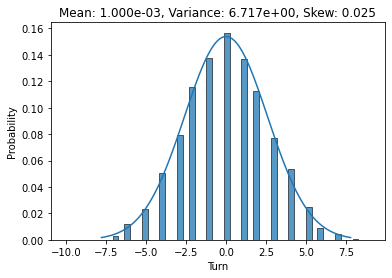

In [171]:
fig = plt.axes()
data = firstprovinceturndiff
mu = data['Turn'].mean()
sigma = data['Turn'].std() 
skew = stats.skew(data['Turn'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), axes=fig)
sns.histplot(x='Turn', data=data, ax=fig, stat='probability')
fig.set_title(f'Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')
plt.show()

From above, we see that the difference in turn between first Province buy is basically normal with zero mean, so both players buy first Province at basically the same time, so there is no advantage at this point. 

In [158]:
last_turn_idxs = (p0_df[['Iter', 'Turn']].groupby('Iter').max() - 1)['Turn']

In [159]:
idxs = list(zip(last_turn_idxs.index, last_turn_idxs))

In [161]:
p0_penult_df = p0_df.set_index(['Iter', 'Turn']).loc[idxs]
p1_penult_df = p1_df.set_index(['Iter', 'Turn']).loc[idxs]

In [232]:
p0_win_penult = (p0_penult_df['Score'] > p1_penult_df['Score']).sum().item()
p0_loss_penult = (p0_penult_df['Score'] < p1_penult_df['Score']).sum().item()
p0_tie_penult = (p0_penult_df['Score'] == p1_penult_df['Score']).sum().item()

print(f'P(Winning at penult) = {p0_win_penult / n * 100:.2f}%')
print(f'P(Losing at penult) = {p0_loss_penult / n * 100:.2f}%')
print(f'P(Tied at penult) = {p0_tie_penult / n * 100:.2f}%')

P(Winning at penult) = 43.24%
P(Losing at penult) = 44.96%
P(Tied at penult) = 11.80%


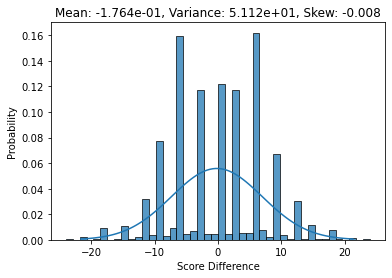

In [172]:
penult_score_diff = p0_penult_df['Score'] - p1_penult_df['Score']

fig = plt.axes()
data = penult_score_diff
mu = data.mean()
sigma = data.std() 
skew = stats.skew(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), axes=fig)
sns.histplot(x=data, ax=fig, stat='probability')
fig.set_title(f'Mean: {mu:.3e}, Variance: {sigma**2:.3e}, Skew: {skew:.3f}')
fig.set_xlabel('Score Difference')
plt.show()

Distribution of scores at the penultimate turn is not normal, but is approximately zero-centered and symmetric. However, starting player is much more likely to be up an Estate. 

<AxesSubplot:xlabel='Turn', ylabel='Score'>

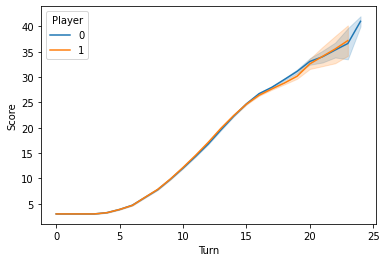

In [26]:
sns.lineplot(x='Turn', y='Score', data=df, hue='Player')

## MLP Simulations ##

In [4]:
model_name = 'r-r-mcts-10k-score'
model_path = os.path.join(model_dir, model_name)
model = torch.load(model_path, map_location='cpu')
model

In [114]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, sandbox=True, num_players=2)
players = load_players(['MLP', 'BM'], [model_path], map_location='cpu', train=False)
agent = players[0]
env = DefaultEnvironment(config, players, logger=logger)

In [117]:
simulate(env, 1, None)

  0%|          | 0/1 [00:00<?, ?it/s]BUY:root:Player 0, Turn 0: Estate
BUY:root:Player 1, Turn 1: Silver
BUY:root:Player 0, Turn 1: Estate
BUY:root:Player 1, Turn 2: Silver
BUY:root:Player 0, Turn 2: Estate
BUY:root:Player 1, Turn 3: Gold
BUY:root:Player 0, Turn 3: Estate
BUY:root:Player 1, Turn 4: Silver
BUY:root:Player 0, Turn 4: Estate
BUY:root:Player 1, Turn 5: Silver
BUY:root:Player 0, Turn 5: None
BUY:root:Player 1, Turn 6: Gold
BUY:root:Player 0, Turn 6: Estate
BUY:root:Player 1, Turn 7: Gold
BUY:root:Player 0, Turn 7: Copper
BUY:root:Player 1, Turn 8: Gold
BUY:root:Player 0, Turn 8: Estate
BUY:root:Player 1, Turn 9: Silver
BUY:root:Player 0, Turn 9: Estate
BUY:root:Player 1, Turn 10: Silver
BUY:root:Player 0, Turn 10: Copper
BUY:root:Player 1, Turn 11: Province
BUY:root:Player 0, Turn 11: Copper
BUY:root:Player 1, Turn 12: Gold
BUY:root:Player 0, Turn 12: Silver
BUY:root:Player 1, Turn 13: Province
BUY:root:Player 0, Turn 13: Copper
BUY:root:Player 1, Turn 14: Gold
BUY:root:Pla

Let's analyze the neural network outputs for some simple cases.

In [20]:
from state import ReducedStateFeature

In [21]:
skip = ReducedStateFeature.default_sandbox_feature()
copper = ReducedStateFeature.default_sandbox_feature()
silver = ReducedStateFeature.default_sandbox_feature()
estate = ReducedStateFeature.default_sandbox_feature()

In [22]:
copper[0] = 45
copper[7] = 8
copper

tensor([45., 10.,  8.,  8.,  8., 40., 30.,  8.,  0.,  3.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [23]:
silver[5] = 39
silver[7+5] = 1
silver

tensor([46., 10.,  8.,  8.,  8., 39., 30.,  7.,  0.,  3.,  0.,  0.,  1.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [24]:
estate[2] = 7
estate[7+2] = 4
estate

tensor([46., 10.,  7.,  8.,  8., 40., 30.,  7.,  0.,  4.,  0.,  0.,  0.,  0.,
         7.,  0.,  3.,  0.,  0.,  0.,  0.])

In [54]:
agent.model(copper), agent.model(silver), agent.model(estate)

TypeError: 'LogisticRegression' object is not callable

## Tree Simulations ##

In [5]:
from mcts import GameTree

In [22]:
tree_name = 'default-r-r-mcts'
tree_path = os.path.join(model_dir, tree_name)
rollout_name = 'default-mlog'
rollout_path = os.path.join(model_dir, rollout_name)

In [10]:
tree_name = 'r-r-mcts-bm-100k-srat-base-default-ucb1-cdecay'
rollout_name = 'mlog-10k-base-default-bm'
tree_path = os.path.join(model_dir, tree_name)
rollout_path = os.path.join(model_dir, rollout_name)

In [11]:
tree = GameTree.load(tree_path, train=False, _skip_level=False, selection='max')

In [42]:
tree.selection = 'secure'
tree.selection

'secure'

In [121]:
tree._root.children[2].children[6].children[14]

Parent: Militia << (n: 1877, v: 1269.0, Q: 0.676 c: Witch) >> Children: [(0, 'Copper', '141', '0.177'), (1, 'Estate', '80', '0.025'), (2, 'Silver', '310', '0.329'), (3, 'Chapel', '503', '0.397'), (4, 'Moat', '538', '0.404'), (5, 'Village', '143', '0.199'), (6, 'None', '161', '0.208')]

In [12]:
# config = GameConfig(splits=[StartingSplit.Starting25Split, StartingSplit.Starting25Split], sandbox=True, num_players=2)
# splits = [StartingSplit.Starting25Split, StartingSplit.Starting25Split]
splits = [StartingSplit.StartingRandomSplit, StartingSplit.StartingRandomSplit]
config = GameConfig(splits=splits, sandbox=False, num_players=2, must_include=default_kingdom)
players = load_players(['UCT', 'DW'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=True)
# agent = load_players(['UCT'], [rollout_path], tree=tree, train=False, rollout_type='mlog', use_tree=False)[0]
# players = [agent, agent]
env = DefaultEnvironment(config, players, logger=logger)

In [21]:
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

In [23]:
sim_data = simulate(env, 1000, tree)

100%|██████████| 1000/1000 [00:24<00:00, 40.35it/s]===SUMMARY===
{0: 593, 1: 437, 'ProvinceWins': 994, 'Ties': 30}



In [12]:
sim_data.game_df

,MaxScore,ProvinceWin,TimeElapsed,Tie
0,40.0,True,0.06635,False


In [97]:
data_dir = os.path.join(project_root, 'data')
data_name ='bm25-bm25-10k-scores'
data_path = os.path.join(data_dir, data_name)

In [98]:
save(data_path, sim_data.player_df)